# set up

In [20]:
##import my packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from itertools import combinations
import community as community_louvain

# import scraped dataset

In [21]:
##manually read in the csv file
#munich_startups = ms
ms = pd.read_csv('../data/output_lat_long-2023-11-13_v3.csv',sep=';')

# convert to long format because all tags are located in one cell, separated by commas

In [22]:
df = ms.copy()

# Load your dataset

# Assuming 'business_title' is the company name and 'business_tags' are the tags
# Split the 'business_tags' into a list (assuming they are separated by commas)
df['tags'] = df['tags'].str.split(',')

# Explode the DataFrame such that each tag gets its own row along with the associated company
long_format_df = df.explode('tags')

# Now, long_format_df has one row for each company-tag pair


# use networx to generate graph and capture x/y coordinates, edges and weights

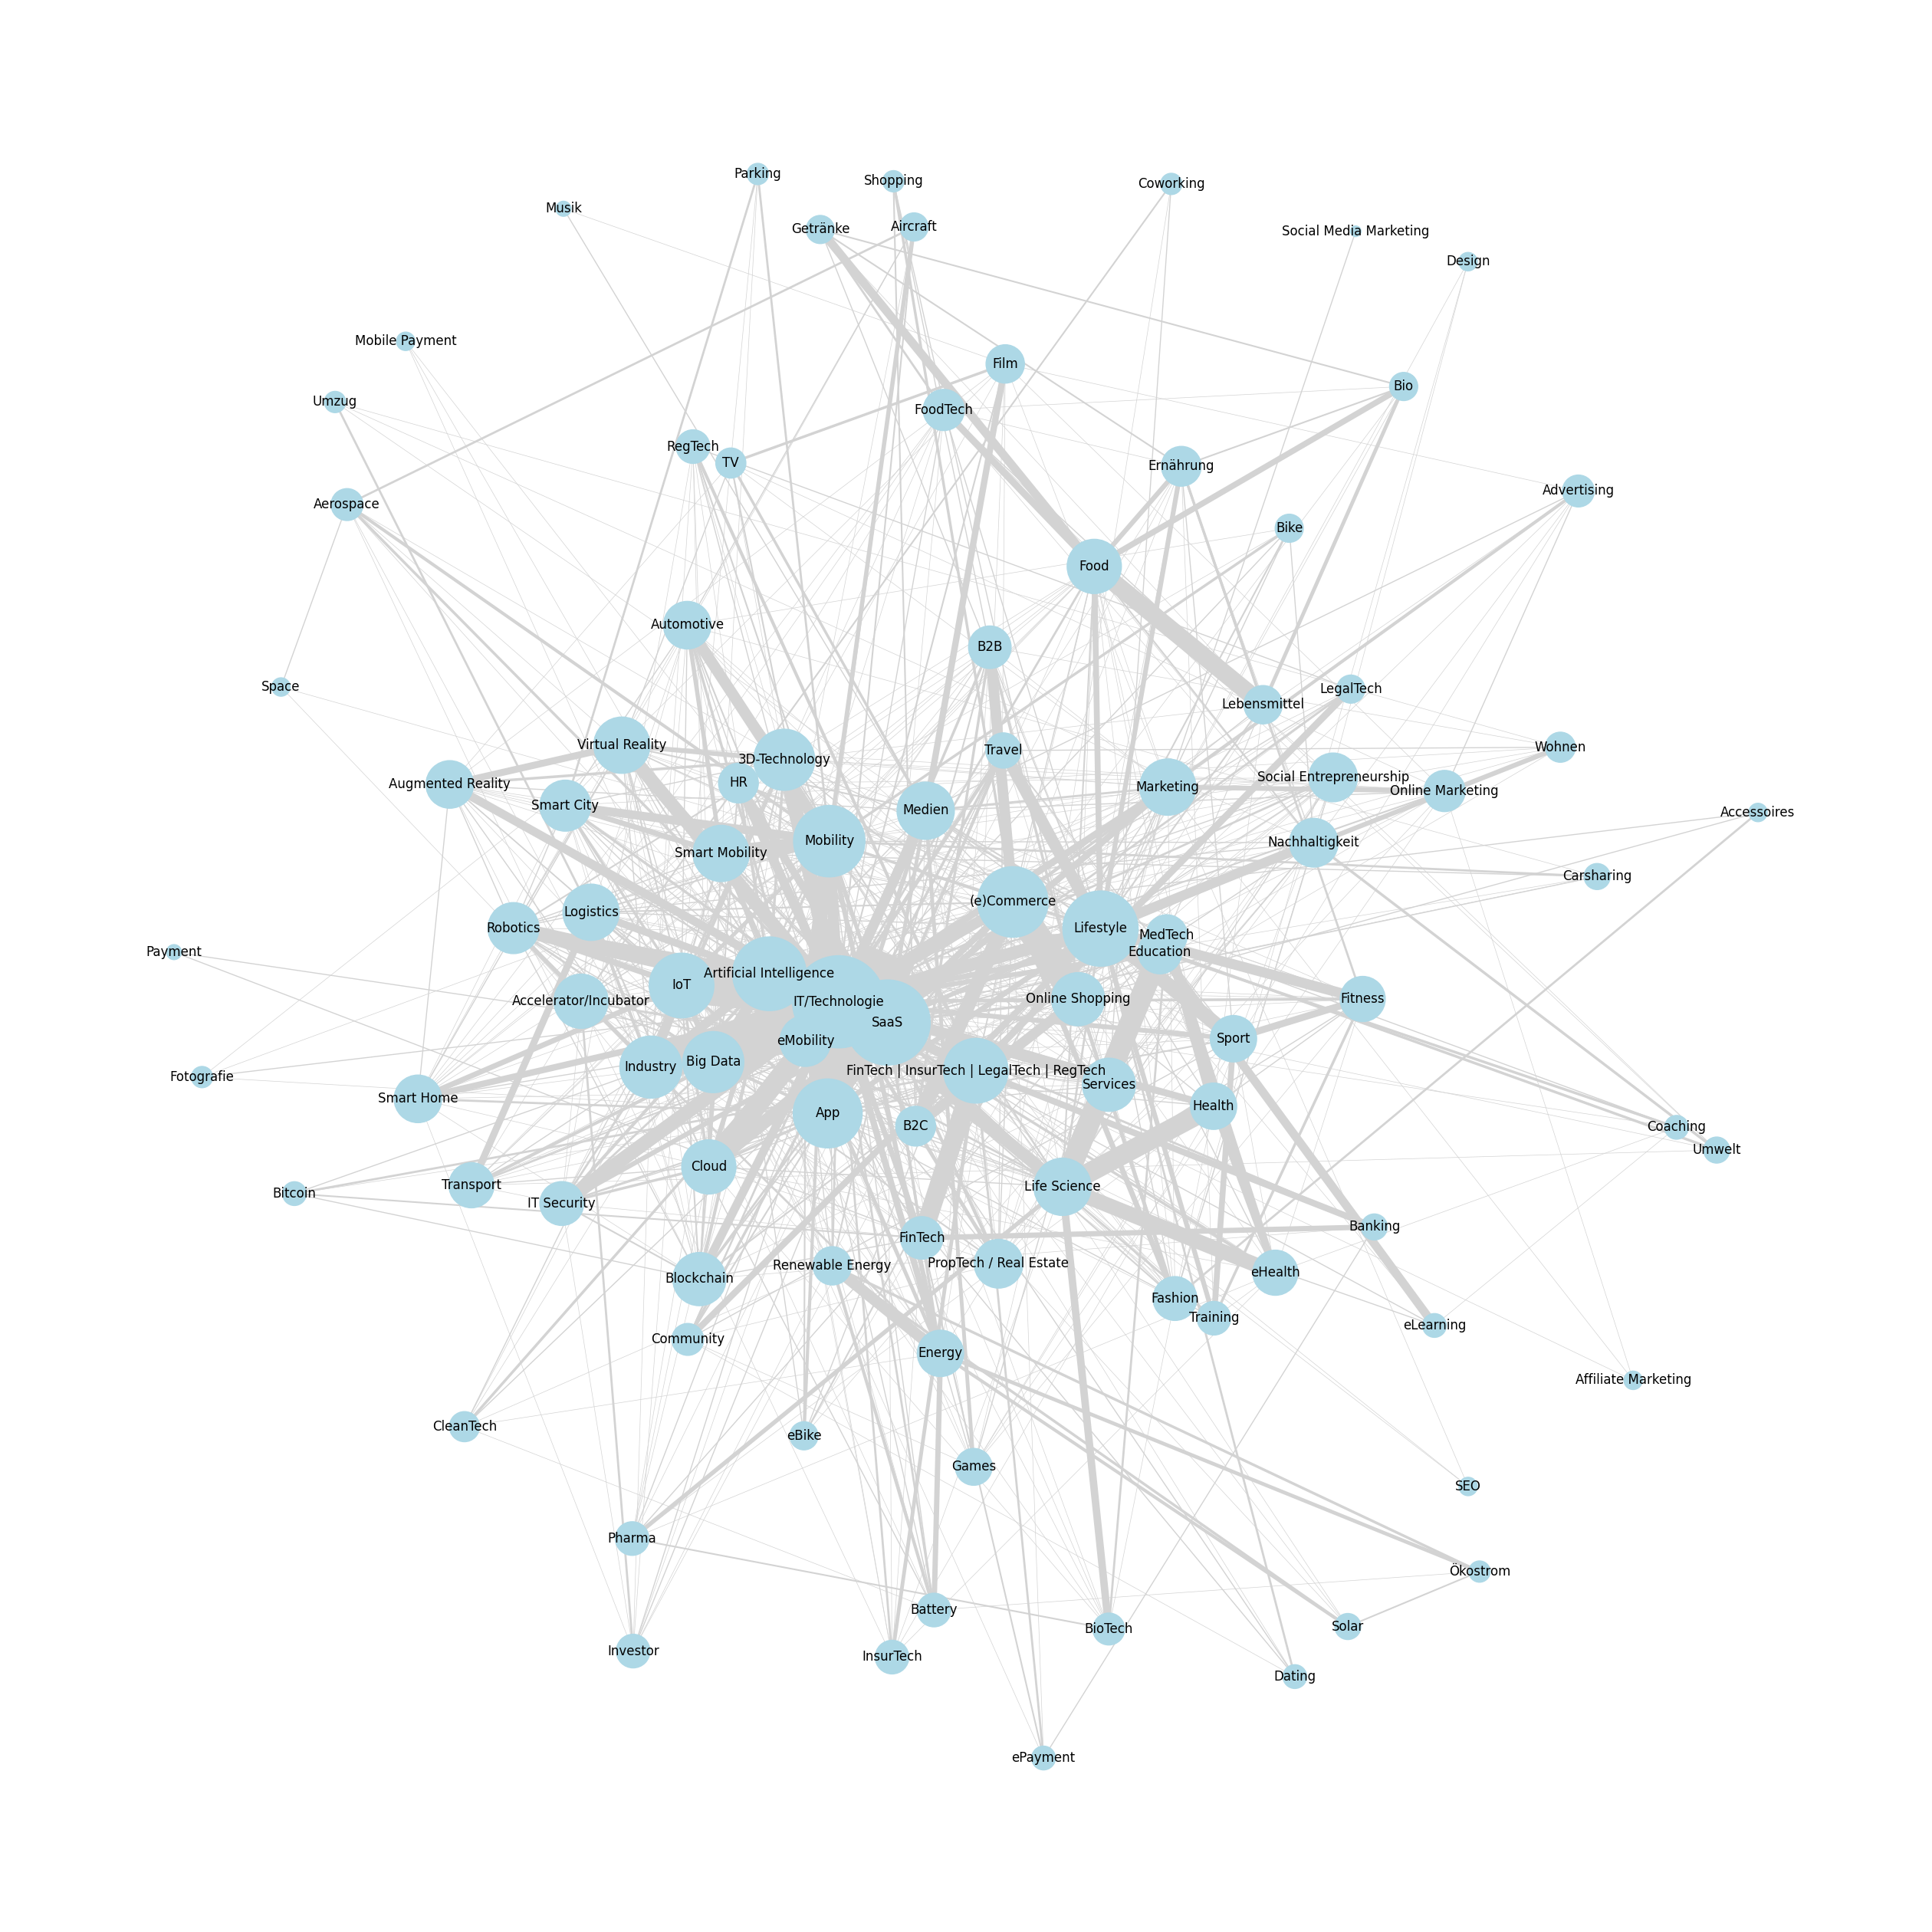

In [23]:
# Create a graph
G = nx.Graph()

# Add edges between all pairs of tags for each company
for company, group in long_format_df.groupby('title'):
    tags = group['tags'].unique()
    for tag1, tag2 in combinations(tags, 2):
        if G.has_edge(tag1, tag2):
            # Increment weight by 1 if the edge already exists
            G[tag1][tag2]['weight'] += 1
        else:
            # Add new edge with weight 1
            G.add_edge(tag1, tag2, weight=1)

# Now, G contains edges between tags that are related (shared by the same company)

# Calculate degrees
degrees = [G.degree(n) for n in G.nodes()]

# Scale node sizes (you can adjust the scaling factor as needed)
node_sizes = [deg * 100 for deg in degrees]

# # Detect communities
# partition = community_louvain.best_partition(G)

# # Create a color map based on communities
# colors = [partition[node] for node in G.nodes()]

# Draw the graph with node sizes
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G,k=1.5)
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='lightblue', edge_color='lightgrey',width=[w * 0.5 for w in weights])
plt.show()


In [24]:
# calculate the degree of each node (how many connections to other key words exist)

In [25]:

# Calculate the degree of each node (tag)
degrees = dict(G.degree())

positions_df = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
positions_df['Tag'] = positions_df.index
positions_df['Degree'] = positions_df['Tag'].map(degrees)
positions_df['ID'] = range(1,len(positions_df)+1)


# calculate weights

In [26]:
# for edge list without weights
#edges_list = list(G.edges)



# Create a list to store edge data
edges_list2 = []

# Iterate over each edge in the graph and extract the weight
for (node1, node2, data) in G.edges(data=True):
    weight = data['weight']
    edges_list2.append((node1, node2, weight))

# Now edges_list contains tuples of (node1, node2, weight)
edges_list2



[('App', 'IT/Technologie', 81),
 ('App', 'Medien', 8),
 ('App', 'IoT', 6),
 ('App', 'Services', 2),
 ('App', 'FinTech | InsurTech | LegalTech | RegTech', 2),
 ('App', 'Big Data', 6),
 ('App', 'Cloud', 5),
 ('App', 'SaaS', 25),
 ('App', 'Community', 3),
 ('App', 'Lifestyle', 10),
 ('App', 'IT Security', 3),
 ('App', 'Games', 1),
 ('App', 'Sport', 3),
 ('App', 'HR', 2),
 ('App', 'Artificial Intelligence', 7),
 ('App', 'Blockchain', 3),
 ('App', '(e)Commerce', 4),
 ('App', 'Education', 2),
 ('App', 'Travel', 2),
 ('App', 'Mobility', 3),
 ('App', 'Smart Mobility', 2),
 ('App', 'Training', 2),
 ('App', '3D-Technology', 1),
 ('App', 'Augmented Reality', 2),
 ('App', 'Robotics', 2),
 ('App', 'Smart City', 1),
 ('App', 'Smart Home', 4),
 ('App', 'Virtual Reality', 2),
 ('App', 'Industry', 1),
 ('App', 'Automotive', 1),
 ('App', 'Dating', 2),
 ('App', 'Logistics', 1),
 ('App', 'Transport', 1),
 ('App', 'eLearning', 2),
 ('App', 'Fitness', 1),
 ('App', 'Bitcoin', 1),
 ('App', 'Online Shopping', 

# create dataframe with the correct structure for the network nodegraph ( path order, different rows etc)

In [27]:


# Create an empty list to store DataFrame rows
rows_list = []

# # Generate the rows for each pair in the list - for regular edge list
# for node1, node2 in edges_list:
#     rows_list.extend([
#         {'Node Name': node1, 'Relationship ID': f"{node1}->{node2}", 'Name': node1, 'Path Order': 1},
#         {'Node Name': node1, 'Relationship ID': f"{node1}->{node2}", 'Name': node2, 'Path Order': 2},
#         {'Node Name': node2, 'Relationship ID': f"{node2}->{node1}", 'Name': node2, 'Path Order': 1},
#         {'Node Name': node2, 'Relationship ID': f"{node2}->{node1}", 'Name': node1, 'Path Order': 2}
#     ])

# for edge list with weights
for node1, node2, weight in edges_list2:
    rows_list.extend([
        {'Node Name': node1, 'Relationship ID': f"{node1}->{node2}", 'Name': node1, 'Path Order': 1, 'Weight': weight},
        {'Node Name': node1, 'Relationship ID': f"{node1}->{node2}", 'Name': node2, 'Path Order': 2, 'Weight': weight},
        {'Node Name': node2, 'Relationship ID': f"{node2}->{node1}", 'Name': node2, 'Path Order': 1, 'Weight': weight},
        {'Node Name': node2, 'Relationship ID': f"{node2}->{node1}", 'Name': node1, 'Path Order': 2, 'Weight': weight}
    ])

# Convert the list of dictionaries to a DataFrame
output_df = pd.DataFrame(rows_list)

# Sort the DataFrame to match the order in the example
output_df.sort_values(by=['Node Name', 'Relationship ID', 'Path Order'], inplace=True)

# Reset index as the final step
output_df.reset_index(drop=True, inplace=True)


# Assuming positions_df is your DataFrame with positions
output_df = output_df.merge(positions_df, left_on='Name', right_on='Tag')
output_df.drop('Tag', axis=1, inplace=True)

# Save to a CSV file if needed

output_df.sort_values("Weight",ascending=False).head(20)


,Node Name,Relationship ID,Name,Path Order,Weight,X,Y,Degree,ID
1762,IT/Technologie,IT/Technologie->SaaS,SaaS,2,239,-0.090639,-0.090564,64,13
1813,SaaS,SaaS->IT/Technologie,SaaS,1,239,-0.090639,-0.090564,64,13
1021,SaaS,SaaS->IT/Technologie,IT/Technologie,2,239,-0.152033,-0.065476,75,2
985,IT/Technologie,IT/Technologie->SaaS,IT/Technologie,1,239,-0.152033,-0.065476,75,2
339,Artificial Intelligence,Artificial Intelligence->IT/Technologie,Artificial Intelligence,1,95,-0.238709,-0.031567,48,27
932,IT/Technologie,IT/Technologie->Artificial Intelligence,IT/Technologie,1,95,-0.152033,-0.065476,75,2
893,Artificial Intelligence,Artificial Intelligence->IT/Technologie,IT/Technologie,2,95,-0.152033,-0.065476,75,2
382,IT/Technologie,IT/Technologie->Artificial Intelligence,Artificial Intelligence,2,95,-0.238709,-0.031567,48,27
892,App,App->IT/Technologie,IT/Technologie,2,81,-0.152033,-0.065476,75,2
291,IT/Technologie,IT/Technologie->App,App,2,81,-0.165718,-0.200655,42,1


 # Export to csv

In [28]:
# output_df.to_csv('startup_relationships.csv', index=False)
